# Model Training and Evaluation

**Goal**: Train ML models to predict salary categories

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

print('✅ Libraries loaded!')

✅ Libraries loaded!


In [2]:
# Load cleaned data
df = pd.read_csv('data/cleaned_jobs.csv')
print(f'Dataset shape: {df.shape}')
print(f'\nTarget distribution:')
print(df['salary_category'].value_counts())
df.head()

Dataset shape: (672, 3)

Target distribution:
salary_category
High      237
Low       218
Medium    217
Name: count, dtype: int64


,job_title_clean,job_description_clean,salary_category
0,sr data scientist,description the senior data scientist is respo...,High
1,data scientist,secure our nation ignite your future join the ...,High
2,data scientist,overview analysis group is one of the largest ...,High
3,data scientist,job description do you have a passion for data...,High
4,data scientist,data scientist affinity solutions marketing cl...,High


## Step 1: Combine Text Features

In [3]:
# Combine job title and description
df['combined_text'] = df['job_title_clean'] + ' ' + df['job_description_clean']

print('Sample combined text (first 200 chars):')
print(df['combined_text'].iloc[0][:200])

Sample combined text (first 200 chars):
sr data scientist description the senior data scientist is responsible for defining building and improving statistical models to improve business processes and outcomes in one or more healthcare domai


## Step 2: Split Data into Train and Test Sets

In [4]:
# Prepare features and target
X = df['combined_text']
y = df['salary_category']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {len(X_train)} samples')
print(f'Test set: {len(X_test)} samples')
print(f'\nTrain set distribution:')
print(y_train.value_counts())

Training set: 537 samples
Test set: 135 samples

Train set distribution:
salary_category
High      189
Low       174
Medium    174
Name: count, dtype: int64


## Step 3: Convert Text to Numbers (TF-IDF)

In [5]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,  # Use top 1000 words
    min_df=2,           # Word must appear in at least 2 documents
    max_df=0.8,         # Ignore words in more than 80% of documents
    ngram_range=(1, 2)  # Use single words and pairs of words
)

# Fit on training data and transform both train and test
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f'TF-IDF matrix shape: {X_train_tfidf.shape}')
print(f'Number of features: {X_train_tfidf.shape[1]}')
print('\nTop 20 important words:')
print(vectorizer.get_feature_names_out()[:20])

TF-IDF matrix shape: (537, 1000)
Number of features: 1000

Top 20 important words:
['000' '10' '100' 'ability' 'ability to' 'able' 'able to' 'about'
 'about the' 'access' 'access to' 'accommodation' 'accuracy' 'achieve'
 'across' 'across the' 'action' 'actionable' 'active' 'activities']


## Step 4: Train Multiple Models

In [6]:
# Dictionary to store models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f'\n{"="*50}')
    print(f'Training {name}...')
    
    # Train
    model.fit(X_train_tfidf, y_train)
    
    # Predict
    y_pred = model.predict(X_test_tfidf)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'\nClassification Report:')
    print(classification_report(y_test, y_pred))

print(f'\n{"="*50}')
print('Model Comparison:')
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f'{name}: {acc:.4f}')


Training Logistic Regression...
Accuracy: 0.3556

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.38      0.36        48
         Low       0.26      0.23      0.24        44
      Medium       0.44      0.47      0.45        43

    accuracy                           0.36       135
   macro avg       0.35      0.36      0.35       135
weighted avg       0.35      0.36      0.35       135


Training Random Forest...
Accuracy: 0.3407

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.40      0.37        48
         Low       0.29      0.23      0.25        44
      Medium       0.38      0.40      0.39        43

    accuracy                           0.34       135
   macro avg       0.34      0.34      0.34       135
weighted avg       0.34      0.34      0.34       135


Training Naive Bayes...
Accuracy: 0.3852

Classification Report:
              precision    rec

## Step 5: Visualize Results

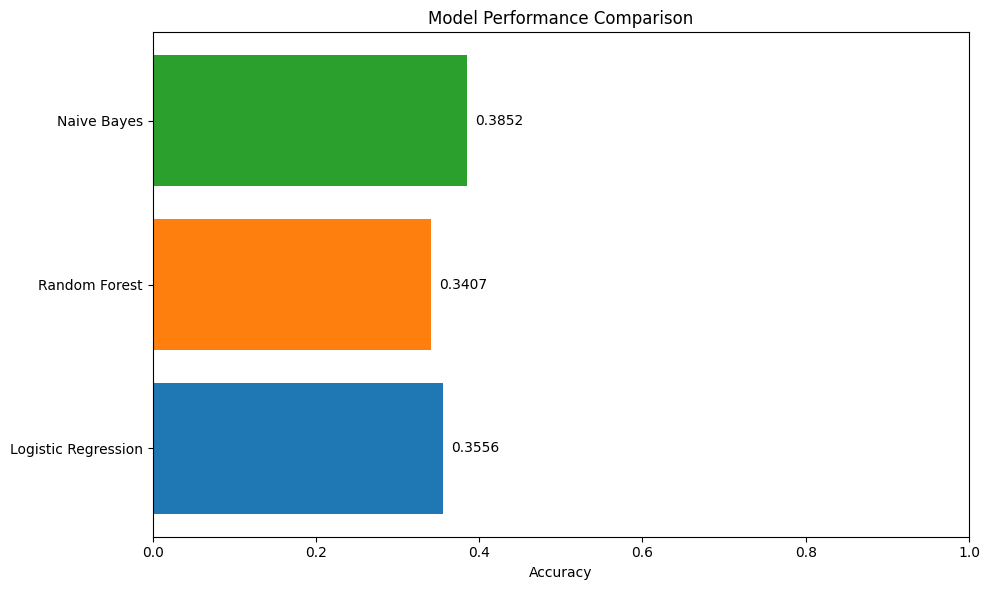

In [7]:
# Plot model comparison
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = list(results.values())

plt.barh(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xlim([0, 1])
for i, v in enumerate(accuracies):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

Best model: Naive Bayes with accuracy 0.3852


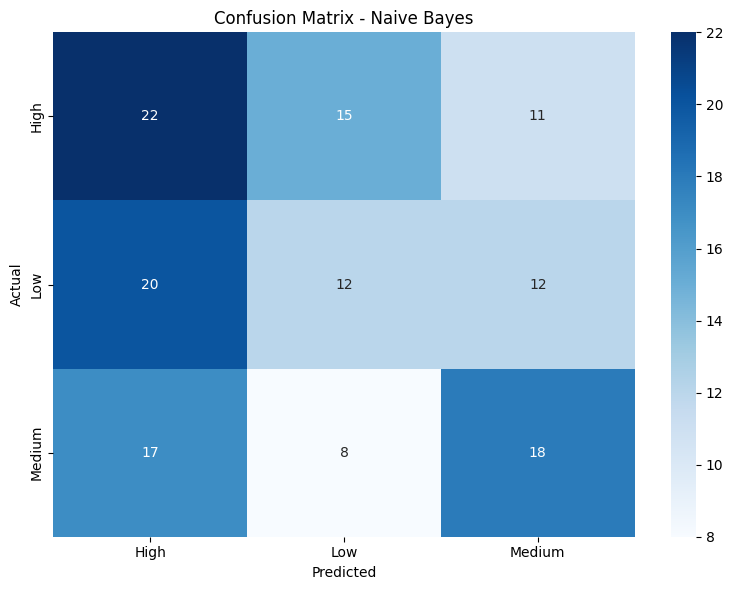

In [8]:
# Get best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f'Best model: {best_model_name} with accuracy {results[best_model_name]:.4f}')

# Confusion matrix for best model
y_pred_best = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

## Step 6: Save the Best Model

In [9]:
# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Save the vectorizer and model
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(best_model, 'models/best_model.pkl')

# Save model info
with open('models/model_info.txt', 'w') as f:
    f.write(f'Best Model: {best_model_name}\n')
    f.write(f'Accuracy: {results[best_model_name]:.4f}\n')
    f.write(f'Training samples: {len(X_train)}\n')
    f.write(f'Test samples: {len(X_test)}\n')
    f.write(f'Features: {X_train_tfidf.shape[1]}\n')

print('✅ Model and vectorizer saved!')
print('\nSaved files:')
print('- models/tfidf_vectorizer.pkl')
print('- models/best_model.pkl')
print('- models/model_info.txt')

✅ Model and vectorizer saved!

Saved files:
- models/tfidf_vectorizer.pkl
- models/best_model.pkl
- models/model_info.txt


## Step 7: Test the Model with New Data

In [10]:
# Function to predict salary for new job postings
def predict_salary_category(job_title, job_description):
    # Combine and clean text
    combined = (job_title + ' ' + job_description).lower()
    
    # Transform using vectorizer
    text_tfidf = vectorizer.transform([combined])
    
    # Predict
    prediction = best_model.predict(text_tfidf)[0]
    probabilities = best_model.predict_proba(text_tfidf)[0]
    
    return prediction, probabilities

# Test examples
test_cases = [
    ('Senior Data Scientist', 'Python machine learning AI deep learning neural networks'),
    ('Junior Data Analyst', 'Excel SQL basic statistics reporting'),
    ('Machine Learning Engineer', 'TensorFlow PyTorch cloud AWS production deployment')
]

print('Testing predictions on sample jobs:\n')
for title, desc in test_cases:
    pred, probs = predict_salary_category(title, desc)
    print(f'Job: {title}')
    print(f'Predicted Category: {pred}')
    print(f'Confidence: High={probs[0]:.2f}, Low={probs[1]:.2f}, Medium={probs[2]:.2f}')
    print('-' * 60)

Testing predictions on sample jobs:

Job: Senior Data Scientist
Predicted Category: High
Confidence: High=0.40, Low=0.28, Medium=0.32
------------------------------------------------------------
Job: Junior Data Analyst
Predicted Category: Low
Confidence: High=0.36, Low=0.48, Medium=0.16
------------------------------------------------------------
Job: Machine Learning Engineer
Predicted Category: Medium
Confidence: High=0.34, Low=0.31, Medium=0.35
------------------------------------------------------------


In [11]:
print('\n=== MODEL TRAINING COMPLETE ===')
print(f'Best Model: {best_model_name}')
print(f'Test Accuracy: {results[best_model_name]:.4f}')
print('\nNext steps:')
print('1. Deploy to Google Cloud Vertex AI')
print('2. Create documentation')
print('3. Clean up cloud resources')


=== MODEL TRAINING COMPLETE ===
Best Model: Naive Bayes
Test Accuracy: 0.3852

Next steps:
1. Deploy to Google Cloud Vertex AI
2. Create documentation
3. Clean up cloud resources
